# Credit Score Classification - Modeling

## 0. Setup and Data Loading

In [64]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from datetime import datetime
import os

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Optuna for hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Advanced models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load pre-split datasets
datasets_dir = 'datasets'

print("Loading datasets...")
print("="*80)

# Load training data
X_train = pd.read_csv(os.path.join(datasets_dir, 'X_train_original.csv'))
y_train = pd.read_csv(os.path.join(datasets_dir, 'y_train_original.csv')).squeeze()

# Load validation data
X_val = pd.read_csv(os.path.join(datasets_dir, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(datasets_dir, 'y_val.csv')).squeeze()

print(f"Training set:   {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")

print("\nClass distribution (Training):")
print(y_train.value_counts().sort_index())

print("\nClass distribution (Validation):")
print(y_val.value_counts().sort_index())

# Get feature names
feature_names = X_train.columns.tolist()
print(f"\nNumber of features: {len(feature_names)}")

Loading datasets...
Training set:   58,294 samples
Validation set: 19,498 samples

Class distribution (Training):
Credit_Score_encoded
0    10353
1    16900
2    31041
Name: count, dtype: int64

Class distribution (Validation):
Credit_Score_encoded
0     3483
1     5662
2    10353
Name: count, dtype: int64

Number of features: 45


## 1. Baseline Model - Logistic Regression

We'll establish a baseline using Logistic Regression with proper scaling for linear models.

In [3]:
print("STEP 1: BASELINE LOGISTIC REGRESSION")
print("="*80)

# Apply StandardScaler for Logistic Regression
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_val_scaled = scaler_lr.transform(X_val)

print("✓ Data scaled for Logistic Regression")

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    solver='lbfgs',
    multi_class='multinomial'
)

lr_model.fit(X_train_scaled, y_train)
print("✓ Model trained")

# Predictions
y_pred_lr = lr_model.predict(X_val_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_val_scaled)

print("\n" + "="*80)
print("LOGISTIC REGRESSION - PERFORMANCE METRICS")
print("="*80)

STEP 1: BASELINE LOGISTIC REGRESSION
✓ Data scaled for Logistic Regression

Training Logistic Regression...
✓ Model trained

LOGISTIC REGRESSION - PERFORMANCE METRICS


In [4]:
# Calculate metrics
lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_f1_macro = f1_score(y_val, y_pred_lr, average='macro')
lr_f1_weighted = f1_score(y_val, y_pred_lr, average='weighted')
lr_precision = precision_score(y_val, y_pred_lr, average='weighted')
lr_recall = recall_score(y_val, y_pred_lr, average='weighted')

# ROC-AUC (One-vs-Rest for multiclass)
lr_roc_auc = roc_auc_score(y_val, y_pred_proba_lr, multi_class='ovr', average='weighted')

print(f"Accuracy:          {lr_accuracy:.4f}")
print(f"F1-Score (Macro):  {lr_f1_macro:.4f}")
print(f"F1-Score (Weighted): {lr_f1_weighted:.4f}")
print(f"Precision:         {lr_precision:.4f}")
print(f"Recall:            {lr_recall:.4f}")
print(f"ROC-AUC:           {lr_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr, 
                          target_names=['Good', 'Poor', 'Standard']))

Accuracy:          0.6413
F1-Score (Macro):  0.6361
F1-Score (Weighted): 0.6450
Precision:         0.6888
Recall:            0.6413
ROC-AUC:           0.7792

Classification Report:
              precision    recall  f1-score   support

        Good       0.48      0.83      0.61      3483
        Poor       0.61      0.67      0.64      5662
    Standard       0.80      0.56      0.66     10353

    accuracy                           0.64     19498
   macro avg       0.63      0.69      0.64     19498
weighted avg       0.69      0.64      0.64     19498



In [5]:
# train metrics
train_y_pred_lr = lr_model.predict(X_train_scaled)
train_y_pred_proba_lr = lr_model.predict_proba(X_train_scaled)

train_lr_accuracy = accuracy_score(y_train, train_y_pred_lr)
train_lr_f1_macro = f1_score(y_train, train_y_pred_lr, average='macro')
train_lr_f1_weighted = f1_score(y_train, train_y_pred_lr, average='weighted')
train_lr_precision = precision_score(y_train, train_y_pred_lr, average='weighted')
train_lr_recall = recall_score(y_train, train_y_pred_lr, average='weighted')
train_lr_roc_auc = roc_auc_score(y_train, train_y_pred_proba_lr, multi_class='ovr')

train_baseline_results = {
    'Model': 'Logistic Regression',
    'Accuracy': train_lr_accuracy,
    'F1_Macro': train_lr_f1_macro,
    'F1_Weighted': train_lr_f1_weighted,
    'Precision': train_lr_precision,
    'Recall': train_lr_recall,
    'ROC_AUC': train_lr_roc_auc
}

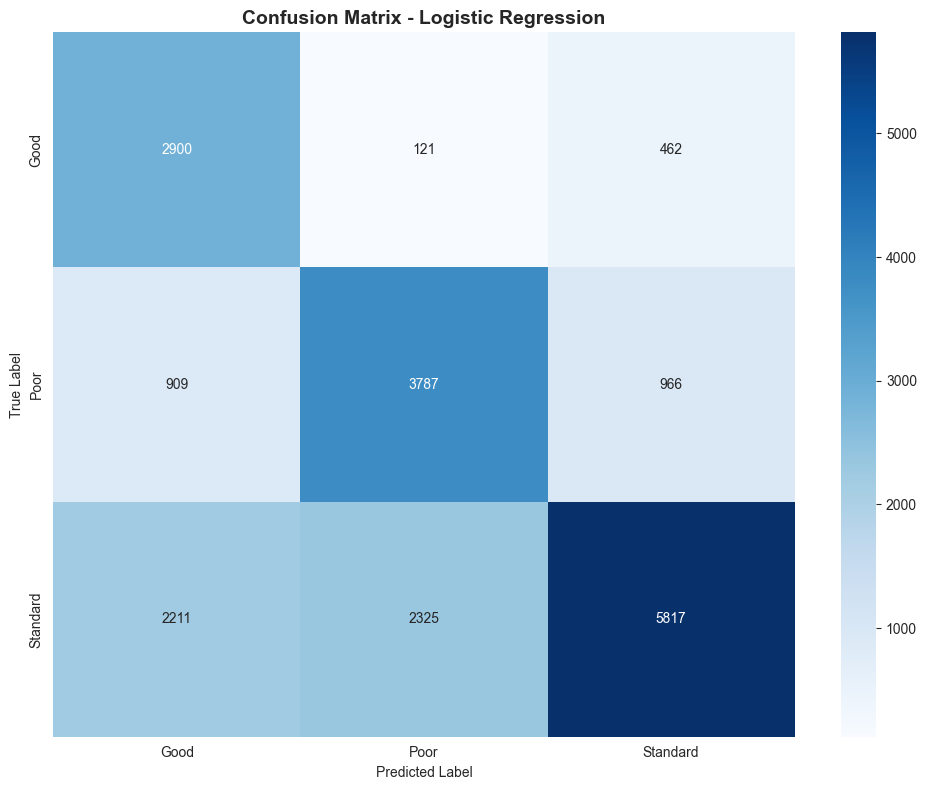

Confusion Matrix:
[[2900  121  462]
 [ 909 3787  966]
 [2211 2325 5817]]


In [6]:
# Confusion Matrix
cm_lr = confusion_matrix(y_val, y_pred_lr)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good', 'Poor', 'Standard'],
            yticklabels=['Good', 'Poor', 'Standard'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm_lr)


Feature Importance Analysis (Top 20 features)

Top 20 Most Important Features:
                                                       Good      Poor  \
Delay_from_due_date                               -0.428867  0.384589   
Credit_Mix_Good                                    0.269278  0.109705   
Total_EMI_per_month_log                            0.279581 -0.143445   
Changed_Credit_Limit                               0.100584 -0.265009   
Num_Credit_Inquiries_log                          -0.100838  0.250711   
Outstanding_Debt                                  -0.184191  0.247952   
Interest_Rate_log                                 -0.137282  0.229345   
Num_Credit_Card_Bin                               -0.222380  0.137239   
Payment_of_Min_Amount_Yes                         -0.221425  0.131335   
has_EMI                                           -0.190731  0.145402   
Monthly_Balance                                   -0.161444  0.161226   
Credit_History_Age                          

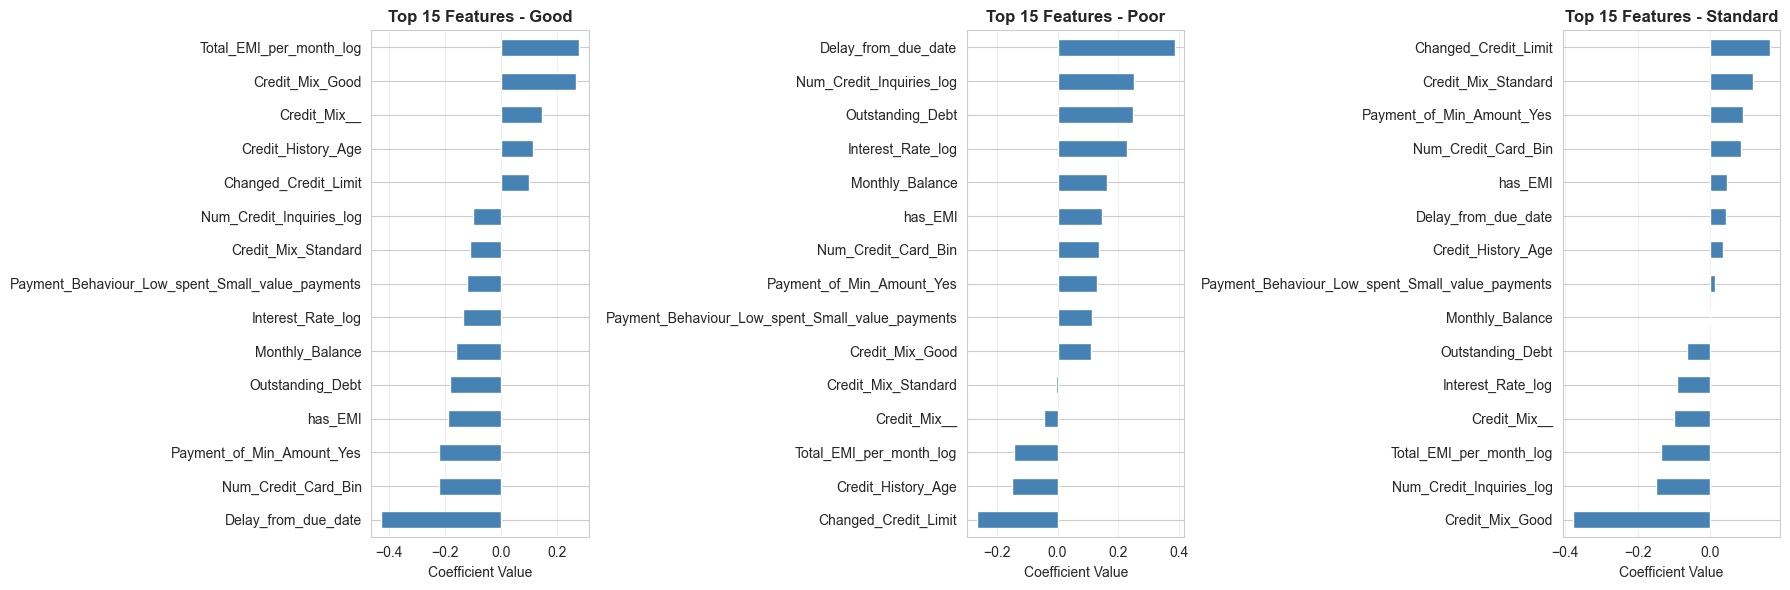


✓ Baseline model established!


In [7]:
# Feature Importance (Coefficients)
print("\nFeature Importance Analysis (Top 20 features)")
print("="*80)

# Get coefficients for each class
coef_df = pd.DataFrame(
    lr_model.coef_.T,
    columns=['Good', 'Poor', 'Standard'],
    index=feature_names
)

# Calculate average absolute coefficient
coef_df['Avg_Abs_Coef'] = coef_df.abs().mean(axis=1)
coef_df_sorted = coef_df.sort_values('Avg_Abs_Coef', ascending=False)

print("\nTop 20 Most Important Features:")
print(coef_df_sorted.head(20))

# Visualize top 15 features
top_features = coef_df_sorted.head(15)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, class_name in enumerate(['Good', 'Poor', 'Standard']):
    top_features[class_name].sort_values().plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'Top 15 Features - {class_name}', fontweight='bold')
    axes[idx].set_xlabel('Coefficient Value')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Save baseline results
baseline_results = {
    'Model': 'Logistic Regression',
    'Accuracy': lr_accuracy,
    'F1_Macro': lr_f1_macro,
    'F1_Weighted': lr_f1_weighted,
    'Precision': lr_precision,
    'Recall': lr_recall,
    'ROC_AUC': lr_roc_auc
}

print("\n✓ Baseline model established!")

## 2. Feature Selection with Tuned Random Forest + RFE

### 2.1 Hyperparameter Tuning with Optuna

In [8]:
# Define objective function
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 15),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Train model
    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred_proba = rf.predict_proba(X_val)
    roc_auc = roc_auc_score(
            y_val,
            y_pred_proba,
            multi_class='ovr',
            average='weighted'
        )
    
    return roc_auc

# Create study
print("Starting Optuna optimization...")
print("This may take several minutes...\n")

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

# Optimize
study.optimize(objective_rf, n_trials=20, show_progress_bar=True)

print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)
print(f"Best ROC AUC: {study.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Save best parameters
best_rf_params = study.best_params
best_rf_params['random_state'] = 42
best_rf_params['n_jobs'] = -1
best_rf_params['class_weight'] = 'balanced'

[I 2025-12-07 17:56:11,637] A new study created in memory with name: no-name-be21b16e-459f-4dec-a434-97fa608978b4


Starting Optuna optimization...
This may take several minutes...



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-07 17:56:14,070] Trial 0 finished with value: 0.8592012792622193 and parameters: {'n_estimators': 175, 'max_depth': 15, 'min_samples_split': 25, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8592012792622193.
[I 2025-12-07 17:56:15,355] Trial 1 finished with value: 0.8537127134557725 and parameters: {'n_estimators': 111, 'max_depth': 14, 'min_samples_split': 22, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.8592012792622193.
[I 2025-12-07 17:56:17,189] Trial 2 finished with value: 0.818162189664648 and parameters: {'n_estimators': 267, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.8592012792622193.
[I 2025-12-07 17:56:18,669] Trial 3 finished with value: 0.8259663155872691 and parameters: {'n_estimators': 186, 'max_depth': 8, 'min_samples_split': 22, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.85920127926

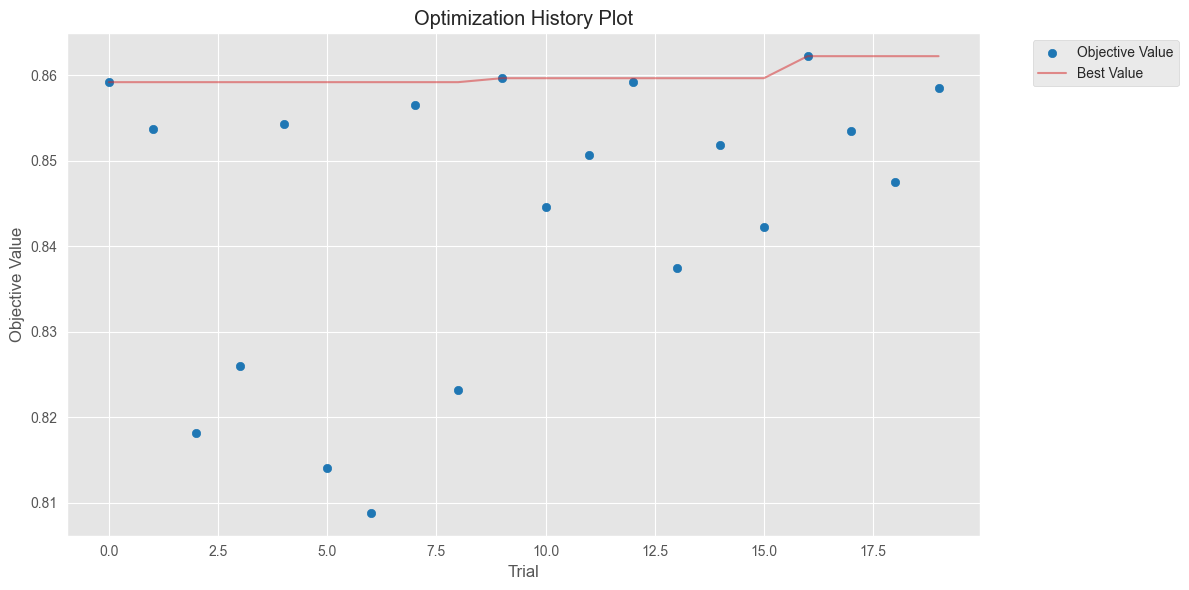

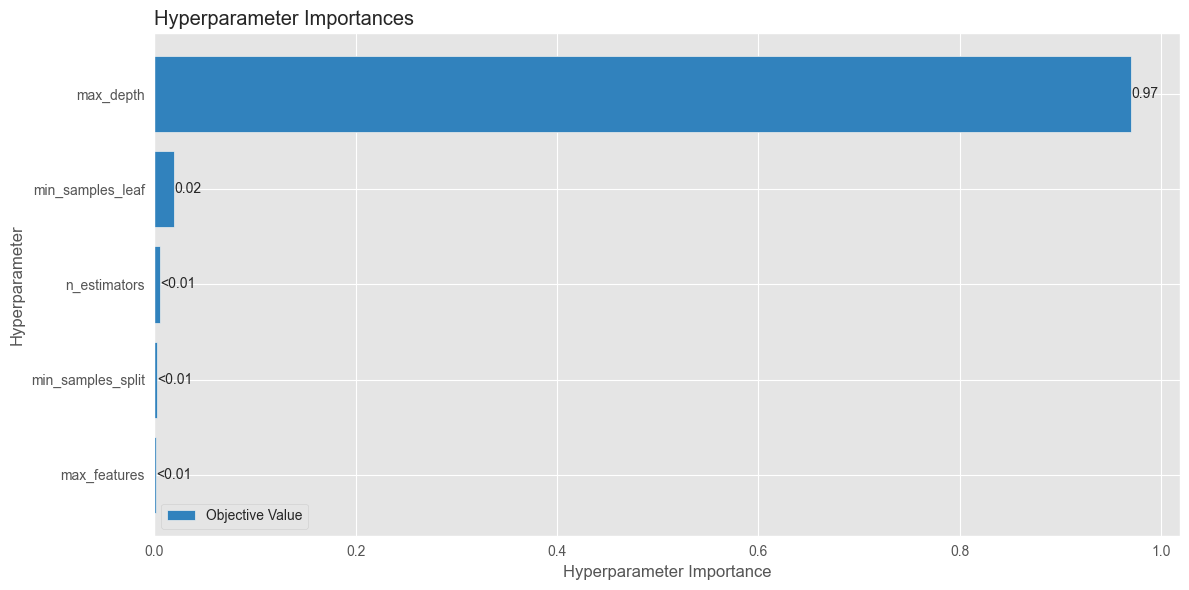

In [9]:
# Optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
axes[0].set_title('Optimization History', fontweight='bold')

# Parameter importances
optuna.visualization.matplotlib.plot_param_importances(study)
axes[1].set_title('Parameter Importances', fontweight='bold')

plt.tight_layout()
plt.show()

In [10]:
best_rf_params

{'n_estimators': 255,
 'max_depth': 15,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'random_state': 42,
 'n_jobs': -1,
 'class_weight': 'balanced'}

In [11]:
# best_rf_params = {'n_estimators': 255,
#  'max_depth': 15,
#  'min_samples_split': 10,
#  'min_samples_leaf': 8,
#  'max_features': 'sqrt',
#  'random_state': 42,
#  'n_jobs': -1,
#  'class_weight': 'balanced'}

### 2.2 Recursive Feature Elimination (RFE)


2.2 Recursive Feature Elimination (RFE)
--------------------------------------------------------------------------------
✓ Optimized Random Forest trained

Top 20 Features by Importance:
                        Feature  Importance
25             Outstanding_Debt    0.161436
30            Interest_Rate_log    0.119745
23          Delay_from_due_date    0.075713
7               Credit_Mix_Good    0.062250
8           Credit_Mix_Standard    0.058172
11    Payment_of_Min_Amount_Yes    0.049389
10     Payment_of_Min_Amount_No    0.049304
27           Credit_History_Age    0.048865
41     Num_Credit_Inquiries_log    0.047474
24         Changed_Credit_Limit    0.036792
20          Num_Credit_Card_Bin    0.033787
40   Num_of_Delayed_Payment_log    0.029605
19        Num_Bank_Accounts_Bin    0.027658
29            Annual_Income_log    0.023493
42      Total_EMI_per_month_log    0.023125
22        Monthly_Inhand_Salary    0.020307
21                          Age    0.016281
28              Mont

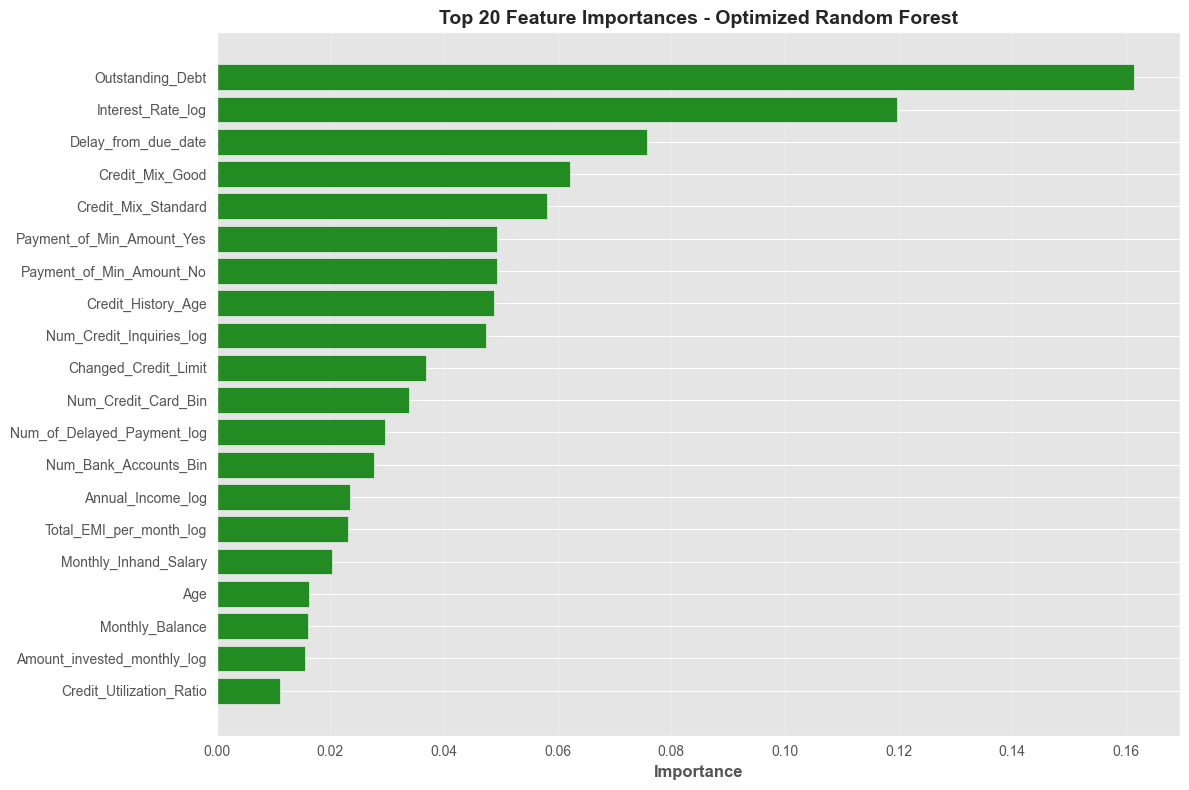

In [11]:
print("\n2.2 Recursive Feature Elimination (RFE)")
print("-"*80)

# Train optimized Random Forest
rf_optimized = RandomForestClassifier(**best_rf_params)
rf_optimized.fit(X_train, y_train)

print("✓ Optimized Random Forest trained")

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Visualize feature importances
plt.figure(figsize=(12, 8))
top_20_features = feature_importance.head(20)
plt.barh(range(len(top_20_features)), top_20_features['Importance'], color='forestgreen')
plt.yticks(range(len(top_20_features)), top_20_features['Feature'])
plt.xlabel('Importance', fontweight='bold')
plt.title('Top 20 Feature Importances - Optimized Random Forest', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Apply RFE to select optimal number of features
print("\nApplying RFE...")
print("Testing different numbers of features...\n")

# Test different numbers of features
n_features_to_test = [10, 15, 20, 25, 30, 35, 40]
rfe_results = []

for n_features in n_features_to_test:
    # Create RFE
    rfe = RFE(
        estimator=RandomForestClassifier(**best_rf_params),
        n_features_to_select=n_features
    )
    
    # Fit RFE
    rfe.fit(X_train, y_train)
    
    # Transform data
    X_train_rfe = rfe.transform(X_train)
    X_val_rfe = rfe.transform(X_val)
    
    # Train model on selected features
    rf_rfe = RandomForestClassifier(**best_rf_params)
    rf_rfe.fit(X_train_rfe, y_train)
    
    # Evaluate
    y_pred_proba_rfe = rf_rfe.predict_proba(X_val_rfe)
    roc_auc_rfe = roc_auc_score(
            y_val,
            y_pred_proba_rfe,
            multi_class='ovr',
            average='weighted'
        )

    y_pred_rfe = rf_rfe.predict(X_val_rfe)
    f1_rfe = f1_score(y_val, y_pred_rfe, average='weighted')
    
    rfe_results.append({
        'n_features': n_features,
        'roc_auc': roc_auc_rfe,
        'f1_score': f1_rfe
    })
    
    print(f"Features: {n_features:2d} | ROC AUC: {roc_auc_rfe:.4f} | F1 (ref): {f1_rfe:.4f}")

# Convert to DataFrame
rfe_results_df = pd.DataFrame(rfe_results)

# Find optimal number of features
best_n_features = rfe_results_df.loc[rfe_results_df['roc_auc'].idxmax(), 'n_features']
best_auc_score = rfe_results_df['roc_auc'].max()
print(f"\n✓ Optimal number of features (by ROC AUC): {int(best_n_features)}")
print(f"  Best ROC AUC: {best_auc_score:.4f}")


Applying RFE...
Testing different numbers of features...

Features: 10 | ROC AUC: 0.8569 | F1 (ref): 0.7207
Features: 15 | ROC AUC: 0.8639 | F1 (ref): 0.7214
Features: 20 | ROC AUC: 0.8585 | F1 (ref): 0.7135
Features: 25 | ROC AUC: 0.8642 | F1 (ref): 0.7139
Features: 30 | ROC AUC: 0.8619 | F1 (ref): 0.7083
Features: 35 | ROC AUC: 0.8627 | F1 (ref): 0.7051
Features: 40 | ROC AUC: 0.8636 | F1 (ref): 0.7107

✓ Optimal number of features (by ROC AUC): 25
  Best ROC AUC: 0.8642


In [19]:
rfe_results_df['roc_auc']

0    0.856940
1    0.863906
2    0.858489
3    0.864187
4    0.861927
5    0.862718
6    0.863562
Name: roc_auc, dtype: float64

In [20]:
best_n_features = 15
best_auc_score = rfe_results_df['roc_auc'][3]

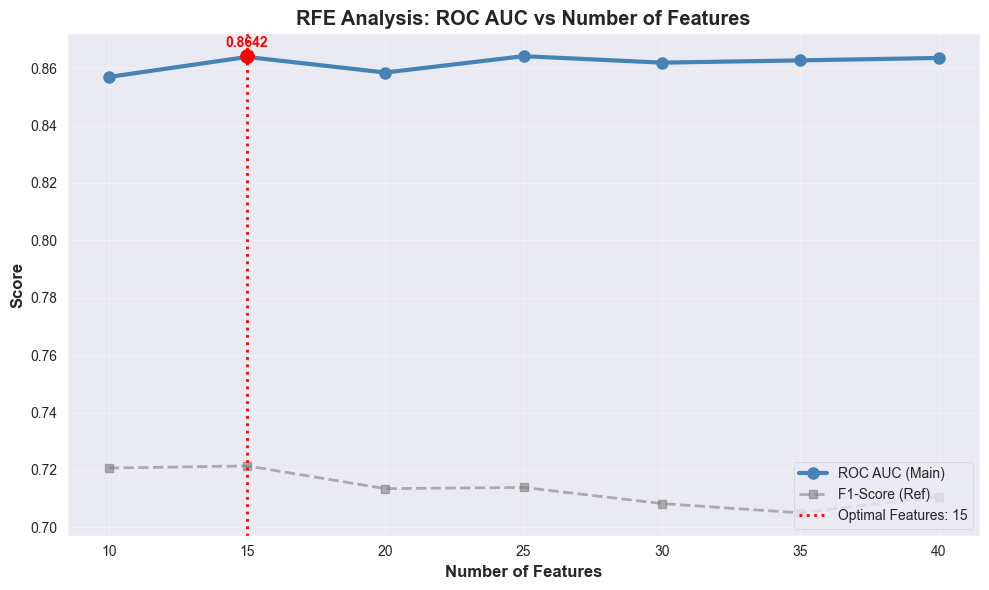

In [21]:
# Visualize RFE results
plt.figure(figsize=(10, 6))

# 1. Main metric: ROC AUC
plt.plot(rfe_results_df['n_features'], rfe_results_df['roc_auc'],
         marker='o', linewidth=3, markersize=8, color='steelblue', label='ROC AUC (Main)')

# 2. Secondary metric: F1-Score (for reference)
plt.plot(rfe_results_df['n_features'], rfe_results_df['f1_score'],
         marker='s', linewidth=2, markersize=6, color='gray', linestyle='--', alpha=0.6, label='F1-Score (Ref)')

# Optimal line (selected by ROC AUC)
plt.axvline(best_n_features, color='red', linestyle=':', linewidth=2,
            label=f'Optimal Features: {int(best_n_features)}')

# Highlight best score
plt.scatter([best_n_features], [best_auc_score], color='red', s=100, zorder=5)
plt.text(best_n_features, best_auc_score + 0.002, f'{best_auc_score:.4f}',
         color='red', fontweight='bold', ha='center', va='bottom')

# Labels and Title
plt.xlabel('Number of Features', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('RFE Analysis: ROC AUC vs Number of Features', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

In [22]:
# Final RFE with optimal number of features
print(f"\nFinal RFE with {int(best_n_features)} features")
print("="*80)

rfe_final = RFE(
    estimator=RandomForestClassifier(**best_rf_params),
    n_features_to_select=int(best_n_features)
)

rfe_final.fit(X_train, y_train)

# Get selected features
selected_features = [f for f, selected in zip(feature_names, rfe_final.support_) if selected]

print(f"\nSelected Features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# Transform datasets
X_train_selected = pd.DataFrame(
    rfe_final.transform(X_train),
    columns=selected_features
)

X_val_selected = pd.DataFrame(
    rfe_final.transform(X_val),
    columns=selected_features
)

print(f"\n✓ Feature selection complete!")
print(f"  Original features: {len(feature_names)}")
print(f"  Selected features: {len(selected_features)}")
print(f"  Reduction: {(1 - len(selected_features)/len(feature_names))*100:.1f}%")


Final RFE with 15 features

Selected Features (15):
 1. Credit_Mix_Good
 2. Credit_Mix_Standard
 3. Payment_of_Min_Amount_No
 4. Payment_of_Min_Amount_Yes
 5. Num_Bank_Accounts_Bin
 6. Num_Credit_Card_Bin
 7. Monthly_Inhand_Salary
 8. Delay_from_due_date
 9. Changed_Credit_Limit
10. Outstanding_Debt
11. Credit_History_Age
12. Annual_Income_log
13. Interest_Rate_log
14. Num_Credit_Inquiries_log
15. Total_EMI_per_month_log

✓ Feature selection complete!
  Original features: 45
  Selected features: 15
  Reduction: 66.7%


In [23]:
selected_features = ["Credit_Mix_Good", "Credit_Mix_Standard", "Payment_of_Min_Amount_No",
                     "Payment_of_Min_Amount_Yes", "Num_Bank_Accounts_Bin",
                     "Num_Credit_Card_Bin", "Monthly_Inhand_Salary",
                     "Delay_from_due_date", "Changed_Credit_Limit",
                     "Outstanding_Debt", "Credit_History_Age",
                     "Annual_Income_log", "Interest_Rate_log",
                     "Num_Credit_Inquiries_log", "Total_EMI_per_month_log"]

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

## 3. Advanced Model Comparison

Now we'll train and compare multiple advanced models using only the selected features.

### 3.1 Random Forest (Tuned)

In [25]:
print("STEP 3: ADVANCED MODEL COMPARISON")
print("="*80)
print("\n3.1 Hyperparameter Tuning on SELECTED Features (Random Forest)")
print("-" * 80)

# 1. Define objective function using SELECTED features
def objective_rf_final(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }

    # Initialize model
    rf = RandomForestClassifier(**params)

    # IMPORTANT: Fit on X_train_selected (the result of RFE)
    rf.fit(X_train_selected, y_train)

    # Predict on validation set
    y_pred_proba = rf.predict_proba(X_val_selected)
    roc_auc = roc_auc_score(
            y_val,
            y_pred_proba,
            multi_class='ovr',
            average='weighted'
        )

    return roc_auc

# 2. Run Optimization
print("Starting Optuna optimization on selected features...")
study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf_final, n_trials=30, show_progress_bar=True)

# 3. Retrieve Best Parameters
print(f"\nBest ROC AUC: {study_rf.best_value:.4f}")
final_rf_params = study_rf.best_params
final_rf_params['random_state'] = 42
final_rf_params['n_jobs'] = -1
final_rf_params['class_weight'] = 'balanced'

[I 2025-12-07 18:20:07,524] A new study created in memory with name: no-name-7e391b3d-6cd7-4e69-a3d7-fb3f52ea32b2


STEP 3: ADVANCED MODEL COMPARISON

3.1 Hyperparameter Tuning on SELECTED Features (Random Forest)
--------------------------------------------------------------------------------
Starting Optuna optimization on selected features...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-07 18:20:10,777] Trial 0 finished with value: 0.8817980767758926 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8817980767758926.
[I 2025-12-07 18:20:16,698] Trial 1 finished with value: 0.8799284753308831 and parameters: {'n_estimators': 447, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8817980767758926.
[I 2025-12-07 18:20:21,468] Trial 2 finished with value: 0.841107938796667 and parameters: {'n_estimators': 172, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.8817980767758926.
[I 2025-12-07 18:20:23,037] Trial 3 finished with value: 0.8546240761904125 and parameters: {'n_estimators': 155, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8817980767758926

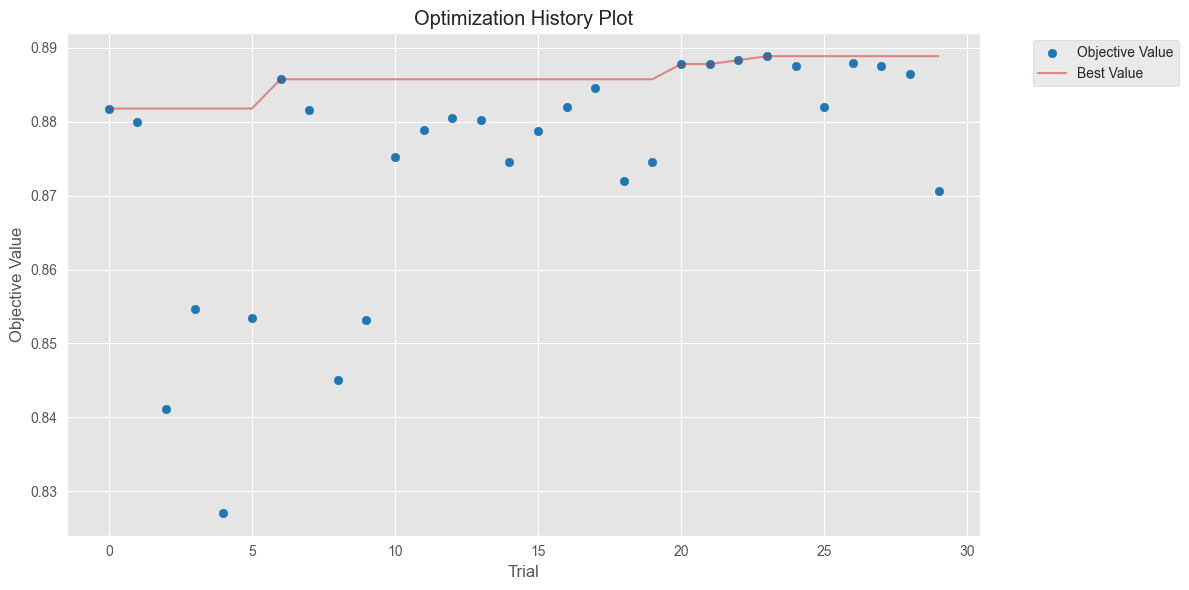

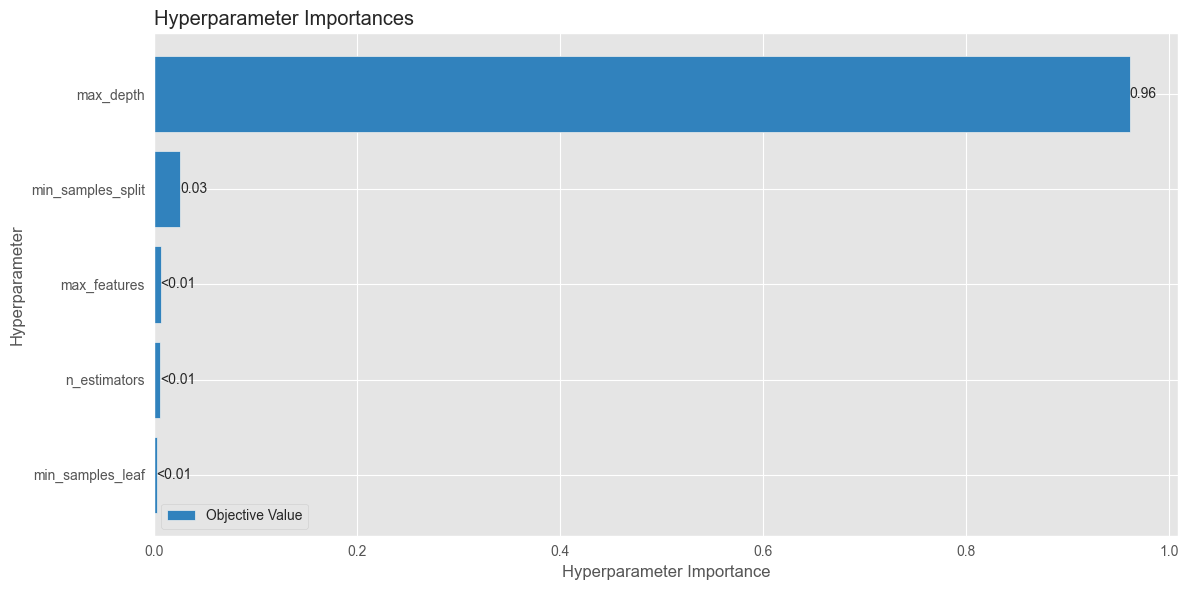

In [26]:
# Optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

# Parameter importances
optuna.visualization.matplotlib.plot_param_importances(study_rf)

plt.tight_layout()
plt.show()

In [27]:
final_rf_params

{'n_estimators': 447,
 'max_depth': 25,
 'min_samples_split': 11,
 'min_samples_leaf': 3,
 'max_features': None,
 'random_state': 42,
 'n_jobs': -1,
 'class_weight': 'balanced'}

In [4]:
# final_rf_params = {'n_estimators': 447,
#  'max_depth': 25,
#  'min_samples_split': 11,
#  'min_samples_leaf': 3,
#  'max_features': None,
#  'random_state': 42,
#  'n_jobs': -1,
#  'class_weight': 'balanced'}

In [28]:
print("\n3.2 Training Final Model with Best Parameters")
print("-" * 80)

# 4. Train final Random Forest with new params
rf_final = RandomForestClassifier(**final_rf_params)
rf_final.fit(X_train_selected, y_train)

# Predictions
y_pred_rf = rf_final.predict(X_val_selected)
y_pred_proba_rf = rf_final.predict_proba(X_val_selected)

# Metrics
rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_val, y_pred_rf),
    'F1_Macro': f1_score(y_val, y_pred_rf, average='macro'),
    'F1_Weighted': f1_score(y_val, y_pred_rf, average='weighted'),
    'Precision': precision_score(y_val, y_pred_rf, average='weighted'),
    'Recall': recall_score(y_val, y_pred_rf, average='weighted'),
    'ROC_AUC': roc_auc_score(y_val, y_pred_proba_rf, multi_class='ovr', average='weighted')
}

print(f"Accuracy:    {rf_metrics['Accuracy']:.4f}")
print(f"F1-Weighted: {rf_metrics['F1_Weighted']:.4f}")
print(f"ROC-AUC:     {rf_metrics['ROC_AUC']:.4f}")
print("\n✓ Random Forest trained and evaluated")


3.2 Training Final Model with Best Parameters
--------------------------------------------------------------------------------
Accuracy:    0.7775
F1-Weighted: 0.7790
ROC-AUC:     0.8889

✓ Random Forest trained and evaluated


In [29]:
# train metrics
train_y_pred_rf = rf_final.predict(X_train_selected)
train_y_pred_proba_rf = rf_final.predict_proba(X_train_selected)

train_rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_train, train_y_pred_rf),
    'F1_Macro': f1_score(y_train, train_y_pred_rf, average='macro'),
    'F1_Weighted': f1_score(y_train, train_y_pred_rf, average='weighted'),
    'Precision': precision_score(y_train, train_y_pred_rf, average='weighted'),
    'Recall': recall_score(y_train, train_y_pred_rf, average='weighted'),
    'ROC_AUC': roc_auc_score(y_train, train_y_pred_proba_rf, multi_class='ovr', average='weighted')
}

### 3.2 XGBoost (Tuned)

In [31]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [32]:
# Define objective for XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
        'gamma': trial.suggest_float('gamma', 0.1, 2.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5.0),
        'objective': 'multi:softmax',
        'num_class': 3,
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_selected, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_val_selected)

    y_pred_proba = model.predict_proba(X_val_selected)
    roc_auc = roc_auc_score(
            y_val,
            y_pred_proba,
            multi_class='ovr',
            average='weighted'
        )

    return roc_auc
    
    return f1_score(y_val, y_pred, average='weighted')

print("Tuning XGBoost...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print(f"\nBest ROC AUC: {study_xgb.best_value:.4f}")

# Train final model
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'objective': 'multi:softmax', 'num_class': 3, 'random_state': 42, 'n_jobs': -1})

[I 2025-12-07 18:27:54,271] A new study created in memory with name: no-name-10ac0322-595e-404d-891d-bc32bfcc2f13


Tuning XGBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-07 18:28:02,545] Trial 0 finished with value: 0.8926960266259033 and parameters: {'n_estimators': 212, 'max_depth': 12, 'learning_rate': 0.14907884894416698, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 6, 'gamma': 0.21035886311957896, 'reg_alpha': 4.332218967416926, 'reg_lambda': 3.009563908598612}. Best is trial 0 with value: 0.8926960266259033.
[I 2025-12-07 18:28:08,627] Trial 1 finished with value: 0.8448625716940386 and parameters: {'n_estimators': 313, 'max_depth': 3, 'learning_rate': 0.19428287191077892, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 7, 'gamma': 0.4484685687215243, 'reg_alpha': 1.5281687923680933, 'reg_lambda': 2.6285345938448668}. Best is trial 0 with value: 0.8926960266259033.
[I 2025-12-07 18:28:13,701] Trial 2 finished with value: 0.8553489092299426 and parameters: {'n_estimators': 230, 'max_depth': 5, 'learning_rate': 0.1262520499972521, 'subsample': 0.

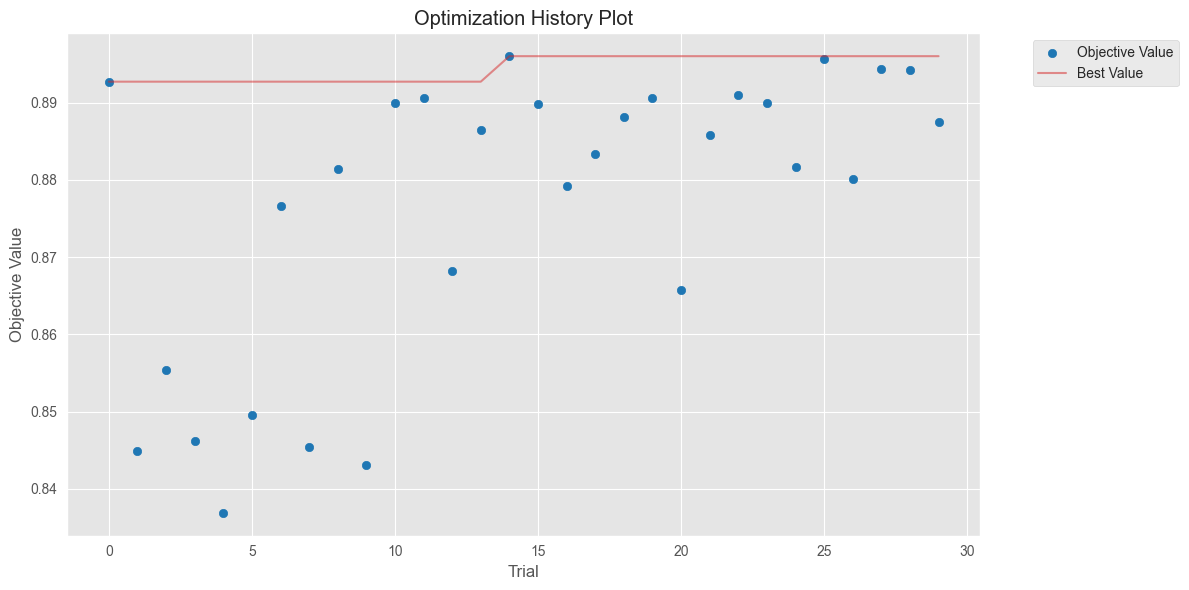

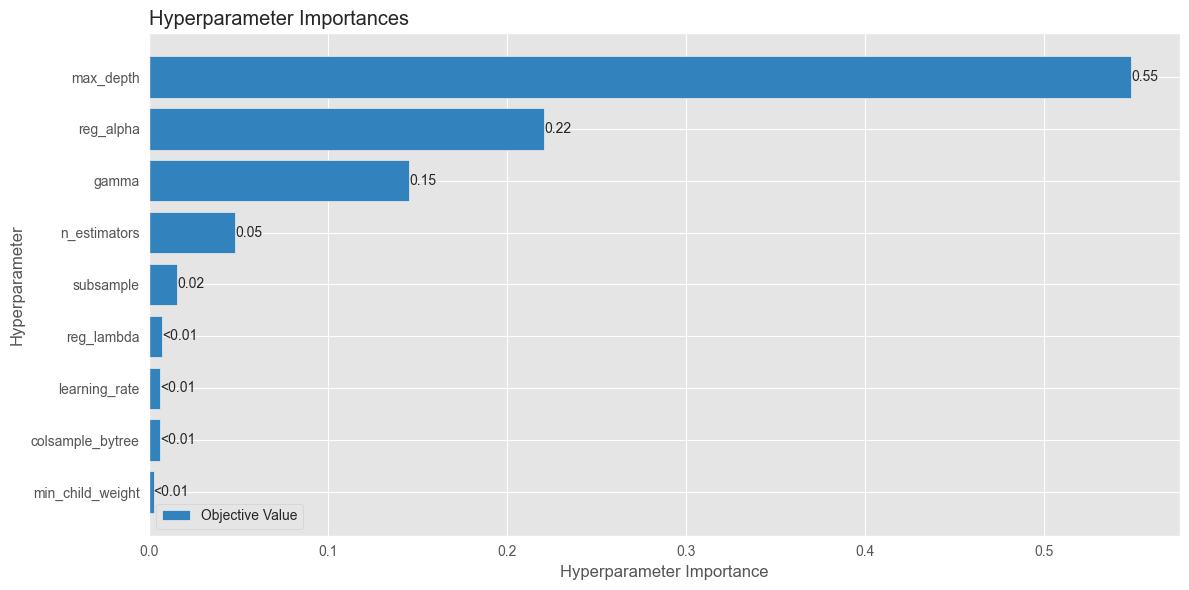

In [33]:
# Optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_xgb)

# Parameter importances
optuna.visualization.matplotlib.plot_param_importances(study_xgb)

plt.tight_layout()
plt.show()

In [34]:
best_xgb_params

{'n_estimators': 338,
 'max_depth': 10,
 'learning_rate': 0.16402190794570823,
 'subsample': 0.7629233097226837,
 'colsample_bytree': 0.9981926492013293,
 'min_child_weight': 11,
 'gamma': 0.2873508910207997,
 'reg_alpha': 2.0059036899247378,
 'reg_lambda': 3.527586142181537,
 'objective': 'multi:softmax',
 'num_class': 3,
 'random_state': 42,
 'n_jobs': -1}

In [ ]:
# best_xgb_params = {'n_estimators': 338,
#  'max_depth': 10,
#  'learning_rate': 0.16402190794570823,
#  'subsample': 0.7629233097226837,
#  'colsample_bytree': 0.9981926492013293,
#  'min_child_weight': 11,
#  'gamma': 0.2873508910207997,
#  'reg_alpha': 2.0059036899247378,
#  'reg_lambda': 3.527586142181537,
#  'objective': 'multi:softmax',
#  'num_class': 3,
#  'random_state': 42,
#  'n_jobs': -1}

In [35]:
xgb_final = xgb.XGBClassifier(**best_xgb_params)
xgb_final.fit(X_train_selected, y_train, sample_weight=sample_weights)

# Predictions
y_pred_xgb = xgb_final.predict(X_val_selected)
y_pred_proba_xgb = xgb_final.predict_proba(X_val_selected)

# Metrics
xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_val, y_pred_xgb),
    'F1_Macro': f1_score(y_val, y_pred_xgb, average='macro'),
    'F1_Weighted': f1_score(y_val, y_pred_xgb, average='weighted'),
    'Precision': precision_score(y_val, y_pred_xgb, average='weighted'),
    'Recall': recall_score(y_val, y_pred_xgb, average='weighted'),
    'ROC_AUC': roc_auc_score(y_val, y_pred_proba_xgb, multi_class='ovr', average='weighted')
}

print(f"Accuracy:    {xgb_metrics['Accuracy']:.4f}")
print(f"F1-Weighted: {xgb_metrics['F1_Weighted']:.4f}")
print(f"ROC-AUC:     {xgb_metrics['ROC_AUC']:.4f}")
print("\n✓ XGBoost trained")

Accuracy:    0.7919
F1-Weighted: 0.7925
ROC-AUC:     0.8960

✓ XGBoost trained


In [36]:
# train metrics
train_y_pred_xgb = xgb_final.predict(X_train_selected)
train_y_pred_proba_xgb = xgb_final.predict_proba(X_train_selected)

train_xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_train, train_y_pred_xgb),
    'F1_Macro': f1_score(y_train, train_y_pred_xgb, average='macro'),
    'F1_Weighted': f1_score(y_train, train_y_pred_xgb, average='weighted'),
    'Precision': precision_score(y_train, train_y_pred_xgb, average='weighted'),
    'Recall': recall_score(y_train, train_y_pred_xgb, average='weighted'),
    'ROC_AUC': roc_auc_score(y_train, train_y_pred_proba_xgb, multi_class='ovr', average='weighted')
}

### 3.3 LightGBM (Tuned)

In [38]:
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 12, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5.0),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_selected, y_train)

    y_pred_proba = model.predict_proba(X_val_selected)
    roc_auc = roc_auc_score(
            y_val,
            y_pred_proba,
            multi_class='ovr',
            average='weighted'
        )

    return roc_auc

print("Tuning LightGBM...")
study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)

print(f"\nBest F1-Score: {study_lgb.best_value:.4f}")

# Train final model
best_lgb_params = study_lgb.best_params
best_lgb_params.update({'random_state': 42, 'n_jobs': -1, 'verbose': -1, 'class_weight': 'balanced'})

[I 2025-12-07 18:34:14,874] A new study created in memory with name: no-name-3dff93bd-f174-4bb2-b921-ea7225b7cad9


Tuning LightGBM...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-07 18:34:16,695] Trial 0 finished with value: 0.8847767144671075 and parameters: {'n_estimators': 212, 'max_depth': 12, 'learning_rate': 0.14907884894416698, 'num_leaves': 68, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'min_child_samples': 14, 'reg_alpha': 4.332218967416926, 'reg_lambda': 3.009563908598612}. Best is trial 0 with value: 0.8847767144671075.
[I 2025-12-07 18:34:17,684] Trial 1 finished with value: 0.8476785848139033 and parameters: {'n_estimators': 313, 'max_depth': 3, 'learning_rate': 0.19428287191077892, 'num_leaves': 87, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'min_child_samples': 19, 'reg_alpha': 1.5281687923680933, 'reg_lambda': 2.6285345938448668}. Best is trial 0 with value: 0.8847767144671075.
[I 2025-12-07 18:34:18,737] Trial 2 finished with value: 0.8622945020678079 and parameters: {'n_estimators': 230, 'max_depth': 5, 'learning_rate': 0.1262520499972521, 'num_leaves': 31, 'subsample': 0.71

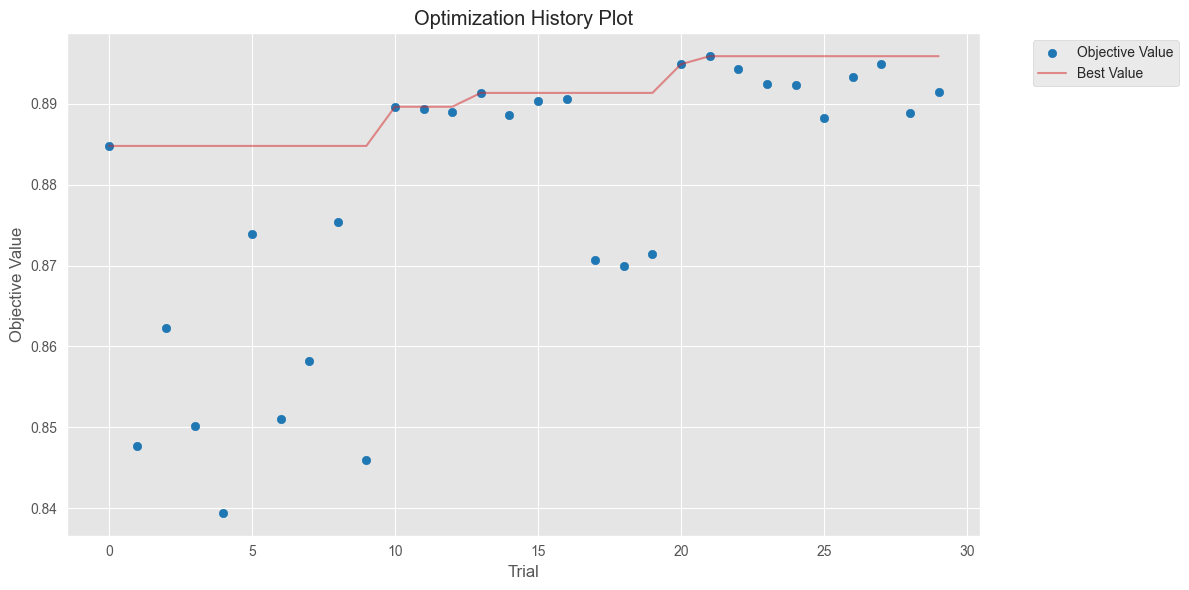

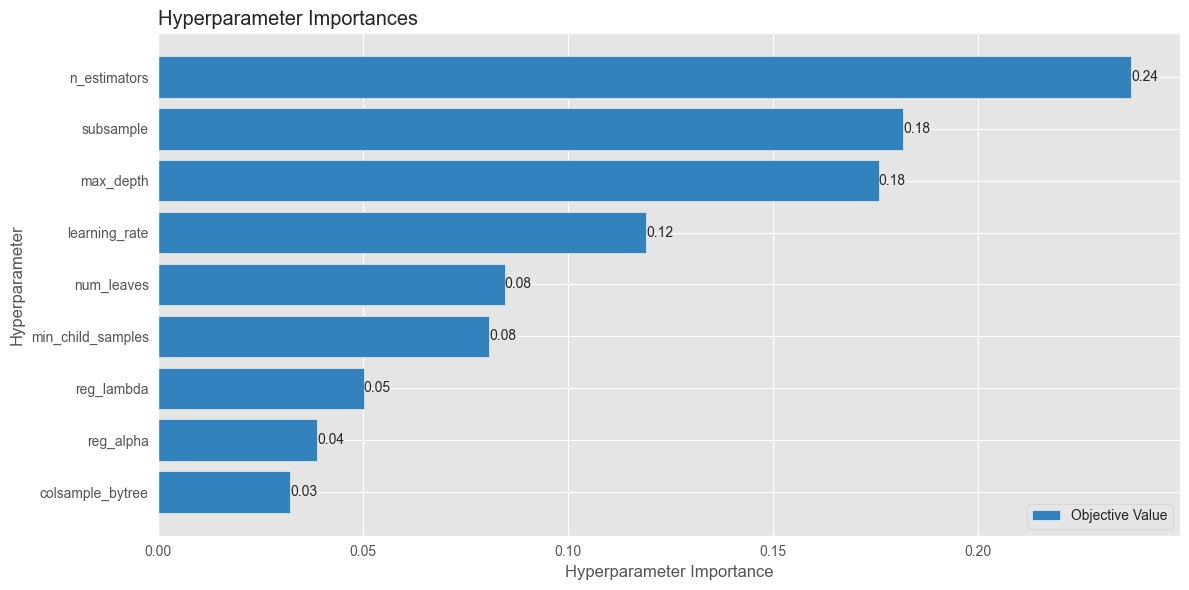

In [39]:
# Optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_lgb)

# Parameter importances
optuna.visualization.matplotlib.plot_param_importances(study_lgb)

plt.tight_layout()
plt.show()

In [40]:
best_lgb_params

{'n_estimators': 361,
 'max_depth': 9,
 'learning_rate': 0.1766345795809385,
 'num_leaves': 71,
 'subsample': 0.7673859573543972,
 'colsample_bytree': 0.737496268451509,
 'min_child_samples': 23,
 'reg_alpha': 2.126062632663457,
 'reg_lambda': 4.8066015791319385,
 'random_state': 42,
 'n_jobs': -1,
 'verbose': -1,
 'class_weight': 'balanced'}

In [24]:
# best_lgb_params = {'n_estimators': 361,
#  'max_depth': 9,
#  'learning_rate': 0.1766345795809385,
#  'num_leaves': 71,
#  'subsample': 0.7673859573543972,
#  'colsample_bytree': 0.737496268451509,
#  'min_child_samples': 23,
#  'reg_alpha': 2.126062632663457,
#  'reg_lambda': 4.8066015791319385,
#  'random_state': 42,
#  'n_jobs': -1,
#  'verbose': -1,
#  'class_weight': 'balanced'}

In [43]:
lgb_final = lgb.LGBMClassifier(**best_lgb_params)
lgb_final.fit(X_train_selected, y_train)

# Predictions
y_pred_lgb = lgb_final.predict(X_val_selected)
y_pred_proba_lgb = lgb_final.predict_proba(X_val_selected)

# Metrics
lgb_metrics = {
    'Model': 'LightGBM',
    'Accuracy': accuracy_score(y_val, y_pred_lgb),
    'F1_Macro': f1_score(y_val, y_pred_lgb, average='macro'),
    'F1_Weighted': f1_score(y_val, y_pred_lgb, average='weighted'),
    'Precision': precision_score(y_val, y_pred_lgb, average='weighted'),
    'Recall': recall_score(y_val, y_pred_lgb, average='weighted'),
    'ROC_AUC': roc_auc_score(y_val, y_pred_proba_lgb, multi_class='ovr', average='weighted')
}

print(f"Accuracy:    {lgb_metrics['Accuracy']:.4f}")
print(f"F1-Weighted: {lgb_metrics['F1_Weighted']:.4f}")
print(f"ROC-AUC:     {lgb_metrics['ROC_AUC']:.4f}")
print("\n✓ LightGBM trained")

Accuracy:    0.7903
F1-Weighted: 0.7908
ROC-AUC:     0.8959

✓ LightGBM trained


In [44]:
# train metrics
train_y_pred_lgb = lgb_final.predict(X_train_selected)
train_y_pred_proba_lgb = lgb_final.predict_proba(X_train_selected)

train_lgb_metrics = {
    'Model': 'LightGBM',
    'Accuracy': accuracy_score(y_train, train_y_pred_lgb),
    'F1_Macro': f1_score(y_train, train_y_pred_lgb, average='macro'),
    'F1_Weighted': f1_score(y_train, train_y_pred_lgb, average='weighted'),
    'Precision': precision_score(y_train, train_y_pred_lgb, average='weighted'),
    'Recall': recall_score(y_train, train_y_pred_lgb, average='weighted'),
    'ROC_AUC': roc_auc_score(y_train, train_y_pred_proba_lgb, multi_class='ovr', average='weighted')
}

### 3.4 CatBoost (Tuned)

In [45]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 400),
        'depth': trial.suggest_int('depth', 4, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 8),
        'auto_class_weights': 'Balanced',
        'random_state': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_selected, y_train)

    y_pred_proba = model.predict_proba(X_val)
    roc_auc = roc_auc_score(
            y_val,
            y_pred_proba,
            multi_class='ovr',
            average='weighted'
        )

    return roc_auc

print("Tuning CatBoost...")
study_cat = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_cat.optimize(objective_cat, n_trials=30, show_progress_bar=True)

print(f"\nBest F1-Score: {study_cat.best_value:.4f}")

# Train final model
best_cat_params = study_cat.best_params
best_cat_params.update({'random_state': 42, 'verbose': 0, 'auto_class_weights': 'Balanced'})

[I 2025-12-07 18:36:43,392] A new study created in memory with name: no-name-c988b59c-28a3-46e5-9f38-0cdbb319116b


Tuning CatBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-07 18:36:55,870] Trial 0 finished with value: 0.8654792414726967 and parameters: {'iterations': 212, 'depth': 9, 'learning_rate': 0.14907884894416698, 'l2_leaf_reg': 5.190609389379256}. Best is trial 0 with value: 0.8654792414726967.
[I 2025-12-07 18:36:57,566] Trial 1 finished with value: 0.8162537616232065 and parameters: {'iterations': 146, 'depth': 4, 'learning_rate': 0.021035886311957897, 'l2_leaf_reg': 7.063233020424546}. Best is trial 0 with value: 0.8654792414726967.
[I 2025-12-07 18:37:06,864] Trial 2 finished with value: 0.8311748068794551 and parameters: {'iterations': 280, 'depth': 8, 'learning_rate': 0.013911053916202464, 'l2_leaf_reg': 7.78936896513396}. Best is trial 0 with value: 0.8654792414726967.
[I 2025-12-07 18:37:18,860] Trial 3 finished with value: 0.8344936503158228 and parameters: {'iterations': 350, 'depth': 5, 'learning_rate': 0.04454674376934912, 'l2_leaf_reg': 2.283831568974037}. Best is trial 0 with value: 0.8654792414726967.
[I 2025-12-07 18:37

In [46]:
best_cat_params

{'iterations': 295,
 'depth': 9,
 'learning_rate': 0.18610015663904886,
 'l2_leaf_reg': 1.6312183706319954,
 'random_state': 42,
 'verbose': 0,
 'auto_class_weights': 'Balanced'}

In [31]:
# best_cat_params = {'iterations': 295,
#  'depth': 9,
#  'learning_rate': 0.18610015663904886,
#  'l2_leaf_reg': 1.6312183706319954,
#  'random_state': 42,
#  'verbose': 0,
#  'auto_class_weights': 'Balanced'}

In [47]:
cat_final = CatBoostClassifier(**best_cat_params)
cat_final.fit(X_train_selected, y_train)

# Predictions
y_pred_cat = cat_final.predict(X_val_selected)
y_pred_proba_cat = cat_final.predict_proba(X_val_selected)

# Metrics
cat_metrics = {
    'Model': 'CatBoost',
    'Accuracy': accuracy_score(y_val, y_pred_cat),
    'F1_Macro': f1_score(y_val, y_pred_cat, average='macro'),
    'F1_Weighted': f1_score(y_val, y_pred_cat, average='weighted'),
    'Precision': precision_score(y_val, y_pred_cat, average='weighted'),
    'Recall': recall_score(y_val, y_pred_cat, average='weighted'),
    'ROC_AUC': roc_auc_score(y_val, y_pred_proba_cat, multi_class='ovr', average='weighted')
}

print(f"Accuracy:    {cat_metrics['Accuracy']:.4f}")
print(f"F1-Weighted: {cat_metrics['F1_Weighted']:.4f}")
print(f"ROC-AUC:     {cat_metrics['ROC_AUC']:.4f}")
print("\n✓ CatBoost trained")

Accuracy:    0.7563
F1-Weighted: 0.7581
ROC-AUC:     0.8788

✓ CatBoost trained


In [48]:
# train metrics
train_y_pred_cat = cat_final.predict(X_train_selected)
train_y_pred_proba_cat = cat_final.predict_proba(X_train_selected)

train_cat_metrics = {
    'Model': 'CatBoost',
    'Accuracy': accuracy_score(y_train, train_y_pred_cat),
    'F1_Macro': f1_score(y_train, train_y_pred_cat, average='macro'),
    'F1_Weighted': f1_score(y_train, train_y_pred_cat, average='weighted'),
    'Precision': precision_score(y_train, train_y_pred_cat, average='weighted'),
    'Recall': recall_score(y_train, train_y_pred_cat, average='weighted'),
    'ROC_AUC': roc_auc_score(y_train, train_y_pred_proba_cat, multi_class='ovr', average='weighted')
}

## 4. Model Comparison & Final Results

In [49]:
print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

# Compile all results
all_results = pd.DataFrame([
    baseline_results,
    rf_metrics,
    xgb_metrics,
    lgb_metrics,
    cat_metrics
])

# Sort by F1-Weighted
all_results = all_results.sort_values('F1_Weighted', ascending=False).reset_index(drop=True)

print("\nPerformance Comparison:")
print(all_results.to_string(index=False))

# Find best model
best_model_name = all_results.iloc[0]['Model']
best_f1 = all_results.iloc[0]['F1_Weighted']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"F1-Score (Weighted): {best_f1:.4f}")
print(f"{'='*80}")


FINAL MODEL COMPARISON

Performance Comparison:
              Model  Accuracy  F1_Macro  F1_Weighted  Precision   Recall  ROC_AUC
            XGBoost  0.791927  0.787613     0.792479   0.801727 0.791927 0.895995
           LightGBM  0.790286  0.786334     0.790817   0.802937 0.790286 0.895868
      Random Forest  0.777516  0.769811     0.779013   0.789406 0.777516 0.888889
           CatBoost  0.756283  0.749948     0.758138   0.778518 0.756283 0.878849
Logistic Regression  0.641297  0.636057     0.644956   0.688806 0.641297 0.779168

BEST MODEL: XGBoost
F1-Score (Weighted): 0.7925


In [45]:
# Compile all train results
train_all_results = pd.DataFrame([
    train_baseline_results,
    train_rf_metrics,
    train_xgb_metrics,
    train_lgb_metrics,
    train_cat_metrics
])

# Sort by F1-Weighted
train_all_results = train_all_results.sort_values('F1_Weighted', ascending=False).reset_index(drop=True)

print(f"\n{'='*80}")
print(f"TRAIN METRICS COMPARISON")
print(f"{'='*80}")

print("\nPerformance Comparison:")
print(train_all_results.to_string(index=False))


TRAIN METRICS COMPARISON

Performance Comparison:
              Model  Accuracy  F1_Macro  F1_Weighted  Precision   Recall  ROC_AUC
            XGBoost  0.892596  0.891994     0.892542   0.906177 0.892596 0.980778
           LightGBM  0.869112  0.868020     0.869014   0.887182 0.869112 0.971573
      Random Forest  0.844529  0.838362     0.845938   0.862081 0.844529 0.970342
           CatBoost  0.755790  0.749682     0.758614   0.796690 0.755790 0.908781
Logistic Regression  0.636566  0.631053     0.640498   0.685334 0.636566 0.798302


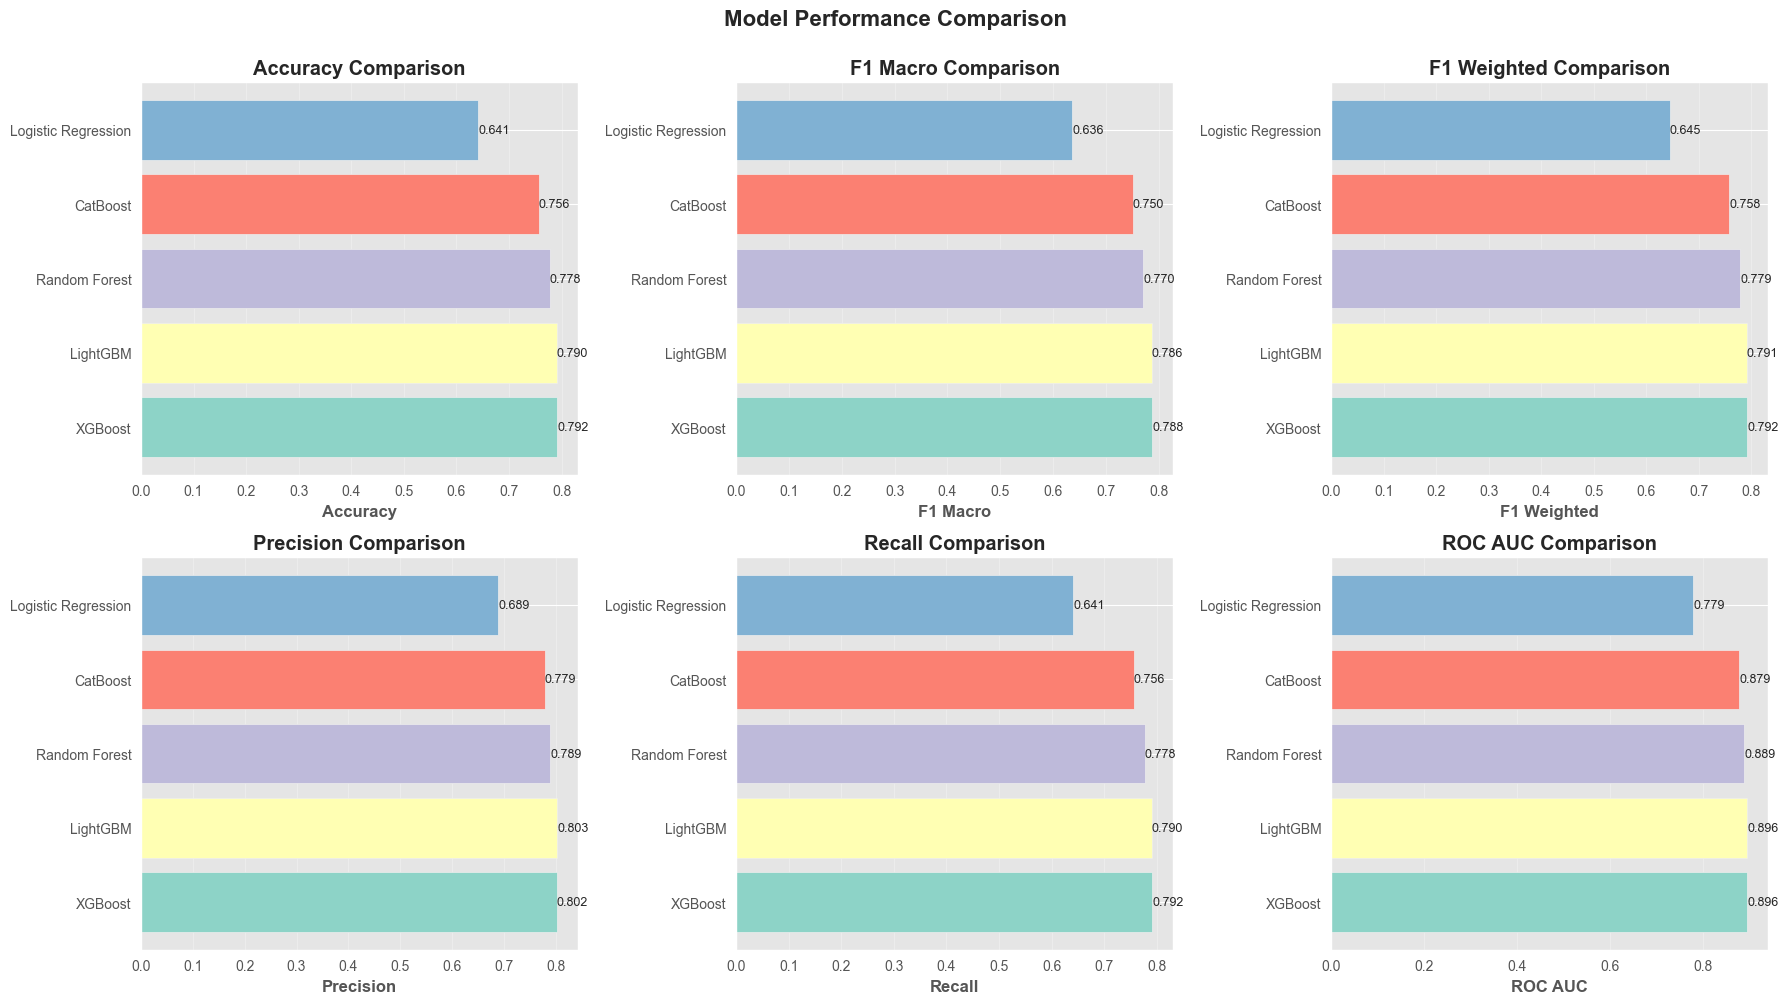

In [50]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics_to_plot = ['Accuracy', 'F1_Macro', 'F1_Weighted', 'Precision', 'Recall', 'ROC_AUC']
colors = plt.cm.Set3(range(len(all_results)))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    bars = ax.barh(all_results['Model'], all_results[metric], color=colors)
    ax.set_xlabel(metric.replace('_', ' '), fontweight='bold')
    ax.set_title(f'{metric.replace("_", " ")} Comparison', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
               f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Final threshold selection for Poor

In [51]:
X_test = pd.read_csv(os.path.join(datasets_dir, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(datasets_dir, 'y_test.csv')).squeeze()

In [52]:
X_test = X_test[selected_features]

In [54]:
class_names = ['Good', 'Poor', 'Standard']

In [70]:
POOR_LABEL = 1

In [71]:
poor_idx = np.where(xgb_final.classes_ == POOR_LABEL)[0][0]

In [82]:
y_val_proba = xgb_final.predict_proba(X_val_selected)

In [83]:
y_scores_poor = y_val_proba[:, poor_idx]

In [84]:
y_val_binary_poor = (y_val == POOR_LABEL).astype(int)

In [85]:
precisions, recalls, thresholds = precision_recall_curve(y_val_binary_poor, y_scores_poor)

In [86]:
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

In [88]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1_val = f1_scores[best_idx]

print(f"Optimal Threshold for 'Poor': {best_threshold:.4f}")
print(f"Max F1-Score for 'Poor': {best_f1_val:.4f}")

Optimal Threshold for 'Poor': 0.3806
Max F1-Score for 'Poor': 0.8056


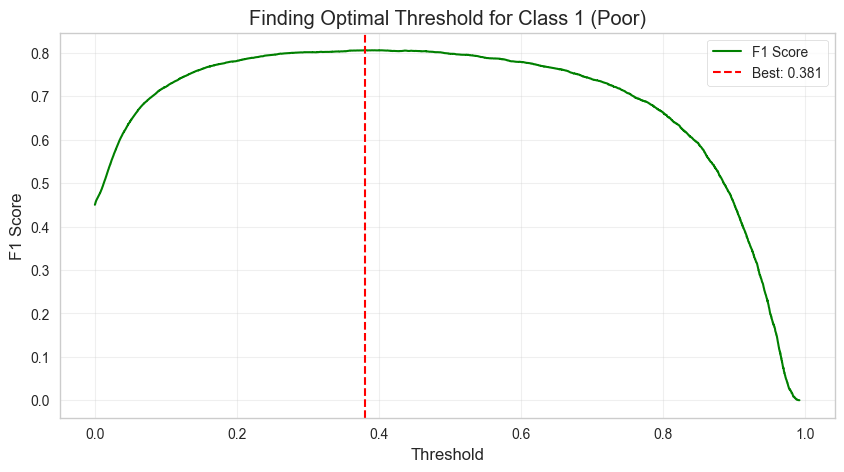

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='green')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold:.3f}')
plt.title(f"Finding Optimal Threshold for Class {POOR_LABEL} (Poor)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Final Evaluation with Custom Threshold...

## Professional Inference Strategy: The "Risk-First" Approach

In standard classification tasks, models typically use the `argmax` approach, selecting the class with the highest probability. However, in the financial sector (Credit Scoring), the cost of error is asymmetric:

-   **False Positive (False Alarm):** We reject a good client. Loss = foregone profit.
-   **False Negative (Missed Risk):** We issue a loan to an insolvent client. Loss = loan principal (default).

Since a default is significantly more costly to the business, we cannot rely on the standard 0.5 threshold or simple probability comparisons.

### Mechanism Logic

We implement a hierarchical (cascading) decision-making logic, which we call "Risk-First".

-   **Stage 1: Risk Detection (One-vs-Rest).**
    First, the model tests the hypothesis: "Is this client 'Poor'?". To do this, a specifically calibrated sensitivity **Threshold** is used, optimized to maximize the F1-score for this specific class.
    If $P(Poor) \geq Threshold \rightarrow$ The client is classified as **Poor** (regardless of the probabilities of other classes).

-   **Stage 2: Classifying the Rest (Standard Logic).**
    Only if the client successfully passes the risk check (the probability of default is below the threshold), do we choose between the **Good** and **Standard** classes based on the highest probability principle.

In [92]:
def predict_custom(model, X, threshold, poor_idx, poor_label):
    proba = model.predict_proba(X)
    classes = model.classes_
    predictions = []

    for i in range(len(proba)):
        if proba[i, poor_idx] >= threshold:
            predictions.append(poor_label)
        else:
            proba_row = proba[i].copy()
            proba_row[poor_idx] = -1
            best_class = classes[np.argmax(proba_row)]
            predictions.append(best_class)

    return np.array(predictions)

In [93]:
y_pred_final = predict_custom(xgb_final, X_val_selected, best_threshold, poor_idx, POOR_LABEL)

In [109]:
# val metrics
final_val_y_pred_xgb = predict_custom(xgb_final, X_val_selected, best_threshold, poor_idx, POOR_LABEL)
final_val_y_pred_proba_xgb = xgb_final.predict_proba(X_val_selected)

final_valxgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_val, final_val_y_pred_xgb),
    'F1_Macro': f1_score(y_val, final_val_y_pred_xgb, average='macro'),
    'F1_Weighted': f1_score(y_val, final_val_y_pred_xgb, average='weighted'),
    'Precision': precision_score(y_val, final_val_y_pred_xgb, average='weighted'),
    'Recall': recall_score(y_val, final_val_y_pred_xgb, average='weighted'),
    'ROC_AUC': roc_auc_score(y_val, final_val_y_pred_proba_xgb, multi_class='ovr', average='weighted')
}
final_valxgb_metrics

{'Model': 'XGBoost',
 'Accuracy': 0.7886962765411837,
 'F1_Macro': 0.7854503426272549,
 'F1_Weighted': 0.7887704126173433,
 'Precision': 0.8029627419159683,
 'Recall': 0.7886962765411837,
 'ROC_AUC': 0.8959948354906475}

In [101]:
print(classification_report(y_val, y_pred_final, target_names=class_names))

              precision    recall  f1-score   support

        Good       0.69      0.85      0.76      3483
        Poor       0.74      0.88      0.81      5662
    Standard       0.87      0.72      0.79     10353

    accuracy                           0.79     19498
   macro avg       0.77      0.82      0.79     19498
weighted avg       0.80      0.79      0.79     19498



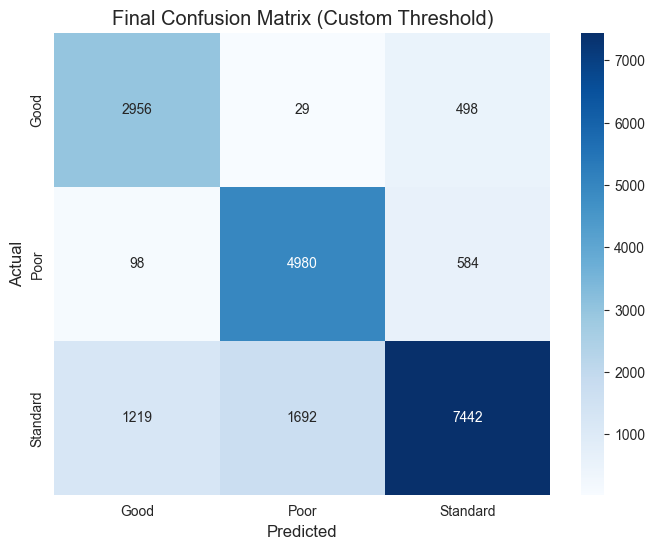

In [102]:
cm = confusion_matrix(y_val, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix (Custom Threshold)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [110]:
# test metrics
test_y_pred_xgb = predict_custom(xgb_final, X_test, best_threshold, poor_idx, POOR_LABEL)
test_y_pred_proba_xgb = xgb_final.predict_proba(X_test)

test_xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, test_y_pred_xgb),
    'F1_Macro': f1_score(y_test, test_y_pred_xgb, average='macro'),
    'F1_Weighted': f1_score(y_test, test_y_pred_xgb, average='weighted'),
    'Precision': precision_score(y_test, test_y_pred_xgb, average='weighted'),
    'Recall': recall_score(y_test, test_y_pred_xgb, average='weighted'),
    'ROC_AUC': roc_auc_score(y_test, test_y_pred_proba_xgb, multi_class='ovr', average='weighted')
}

In [111]:
test_xgb_metrics

{'Model': 'XGBoost',
 'Accuracy': 0.7823580875919922,
 'F1_Macro': 0.7779434491865826,
 'F1_Weighted': 0.7824432211055359,
 'Precision': 0.798035239956946,
 'Recall': 0.7823580875919922,
 'ROC_AUC': 0.8931256737821902}

In [112]:
# Save results and models
print("\nSaving results and models...")
print("="*80)

# Save results
all_results.to_csv('model_comparison_results.csv', index=False)
print("✓ Results saved to 'model_comparison_results.csv'")

# Save selected features
pd.DataFrame({'Selected_Features': selected_features}).to_csv('selected_features.csv', index=False)
print(f"✓ Selected features saved ({len(selected_features)} features)")

# Save best models
models_to_save = {
    'xgboost': xgb_final,
}

for name, model in models_to_save.items():
    joblib.dump(model, f'{name}_model.pkl')
    print(f"✓ {name} saved")


Saving results and models...
✓ Results saved to 'model_comparison_results.csv'
✓ Selected features saved (15 features)
✓ xgboost saved


In [115]:
(best_threshold, poor_idx, POOR_LABEL)

(np.float32(0.38059428), np.int64(1), 1)

In [116]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import shap

1. FINAL MODEL EVALUATION REPORT (XGBoost)
Accuracy: 0.7824
F1_Macro: 0.7779
F1_Weighted: 0.7824
Precision: 0.7980
Recall: 0.7824
ROC_AUC: 0.8931

Classification Report:

              precision    recall  f1-score   support

        Good       0.68      0.83      0.75      3458
        Poor       0.74      0.88      0.81      5644
    Standard       0.87      0.71      0.78     10329

    accuracy                           0.78     19431
   macro avg       0.76      0.81      0.78     19431
weighted avg       0.80      0.78      0.78     19431



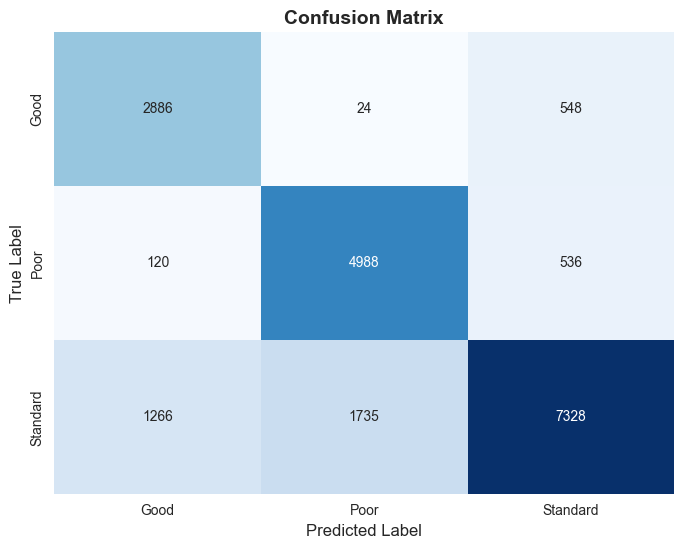

In [117]:
print("="*80)
print("1. FINAL MODEL EVALUATION REPORT (XGBoost)")
print("="*80)

# Predictions
y_pred = predict_custom(xgb_final, X_test, best_threshold, poor_idx, POOR_LABEL)
y_proba = xgb_final.predict_proba(X_test)

for key, value in list(test_xgb_metrics.items())[1:]:
    print(f"{key}: {value:.4f}")

# 1. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# 2. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [118]:
df_metrics = pd.DataFrame([test_xgb_metrics]).melt(id_vars='Model', var_name='Metric', value_name='Score')

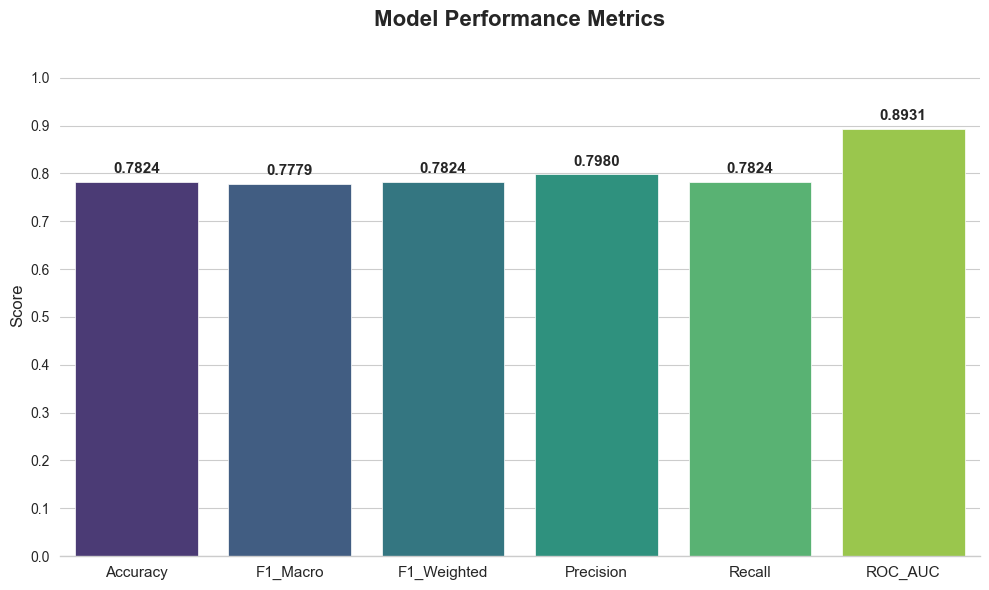

In [119]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(x='Metric', y='Score', data=df_metrics, hue='Metric', palette='viridis', legend=False)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=11, fontweight='bold')

plt.ylim(0, 1.05)
plt.title(f'Model Performance Metrics', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score', fontsize=12)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.yticks(np.arange(0, 1.1, 0.1))

sns.despine(left=True)

plt.tight_layout()
plt.show()

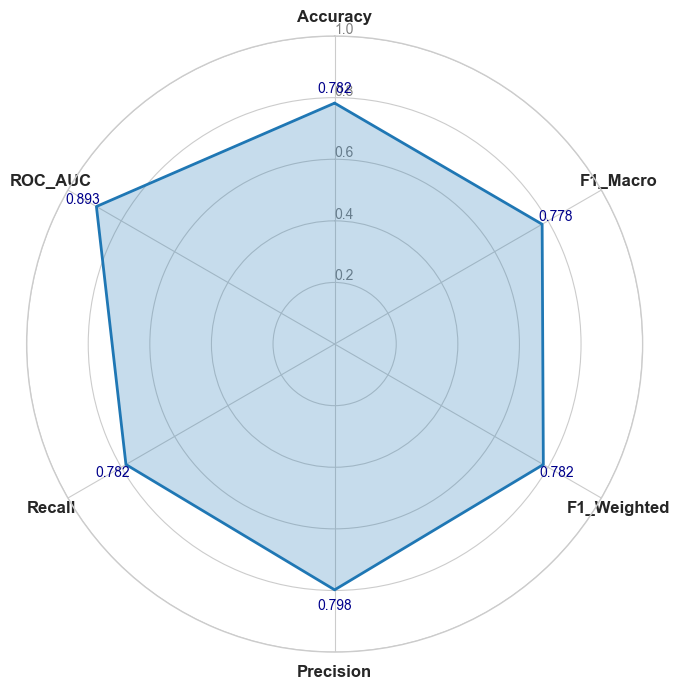

In [120]:
metrics = {k: v for k, v in test_xgb_metrics.items() if k != 'Model'}
labels = list(metrics.keys())
values = list(metrics.values())

num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

values += values[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, values, color='#1f77b4', linewidth=2, linestyle='solid')

ax.fill(angles, values, color='#1f77b4', alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')

ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1.0)

for angle, value, label in zip(angles[:-1], values[:-1], labels):
    ax.text(angle, value + 0.05, f"{value:.3f}", ha='center', va='center', fontsize=10, color='darkblue')

plt.show()

2. ROC & PRECISION-RECALL CURVES


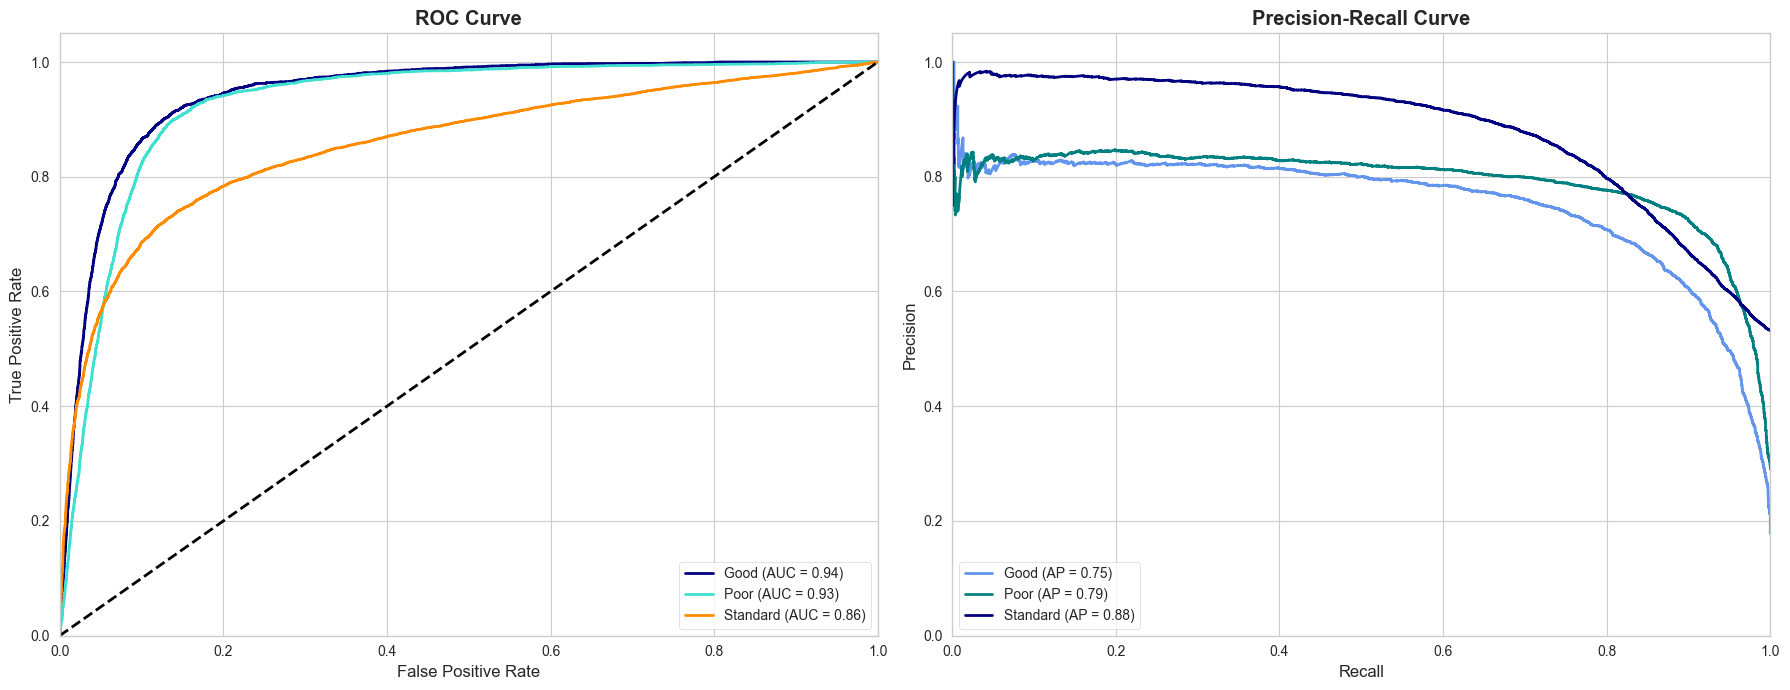

In [121]:
print("="*80)
print("2. ROC & PRECISION-RECALL CURVES")
print("="*80)

# Binarize the output for multiclass ROC/PR plotting
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

# --- ROC Curve ---
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:0.2f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontweight='bold')
ax1.legend(loc="lower right")

# --- Precision-Recall Curve ---
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    ax2.plot(recall, precision, color=color, lw=2,
             label=f'{class_names[i]} (AP = {avg_precision:0.2f})')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontweight='bold')
ax2.legend(loc="lower left")
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

3. FEATURE IMPORTANCE ANALYSIS


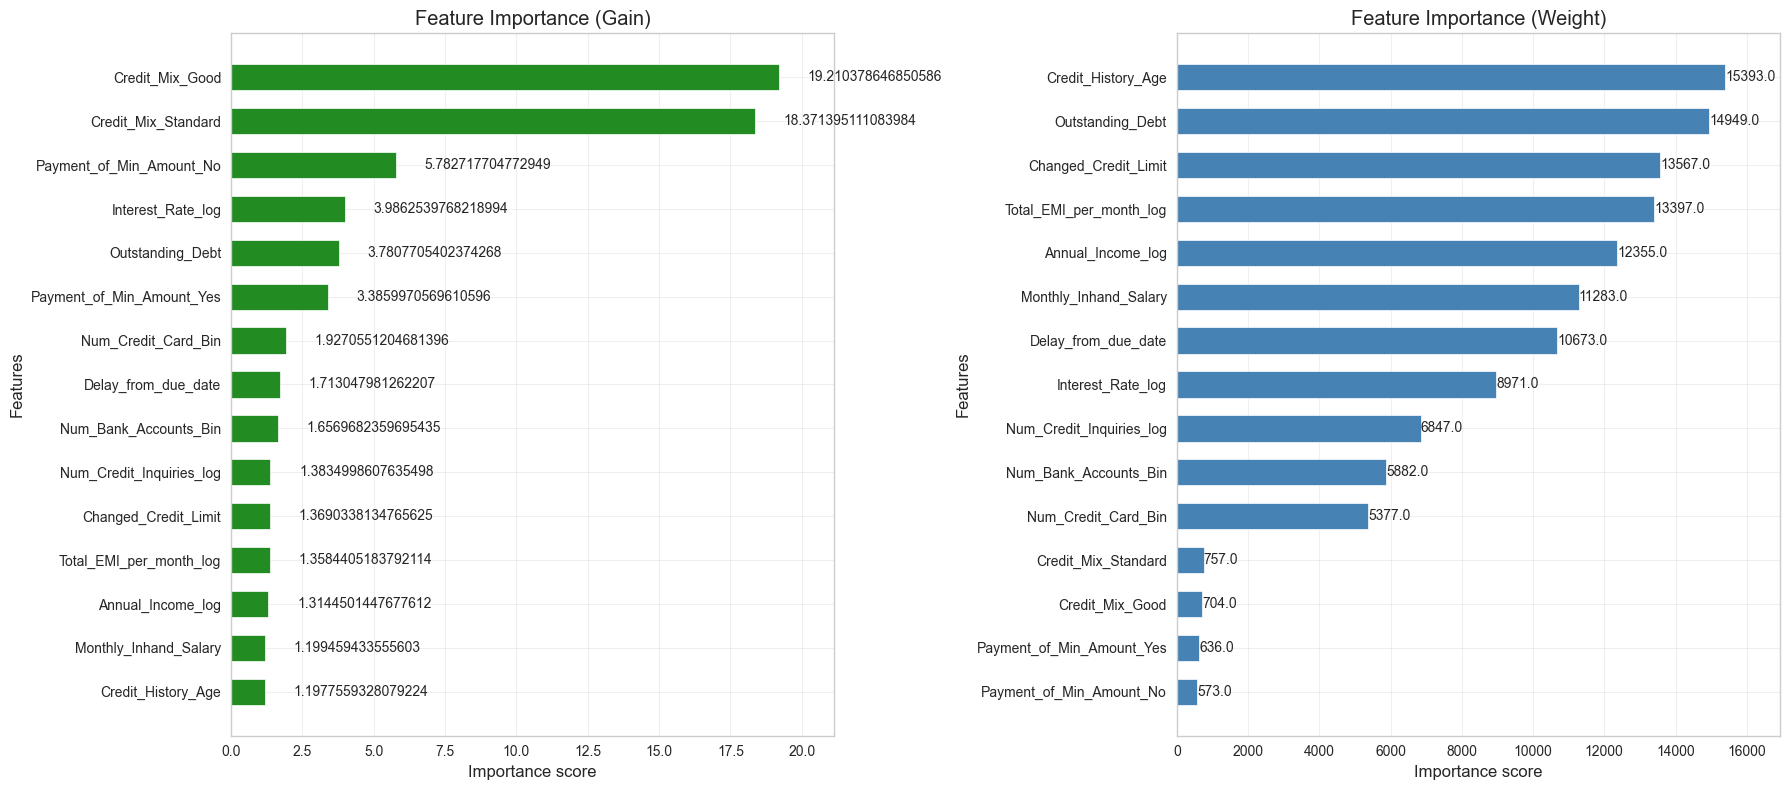

In [122]:
print("="*80)
print("3. FEATURE IMPORTANCE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Gain Importance (Contribution to accuracy)
xgb.plot_importance(xgb_final, importance_type='gain', max_num_features=15,
                    ax=axes[0], height=0.6, title='Feature Importance (Gain)', color='forestgreen')
axes[0].grid(alpha=0.3)

# 2. Weight Importance (Frequency in trees)
xgb.plot_importance(xgb_final, importance_type='weight', max_num_features=15,
                    ax=axes[1], height=0.6, title='Feature Importance (Weight)', color='steelblue')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

4. SHAP VALUES (Model Explainability)
SHAP Summary Plot (Impact on model output):


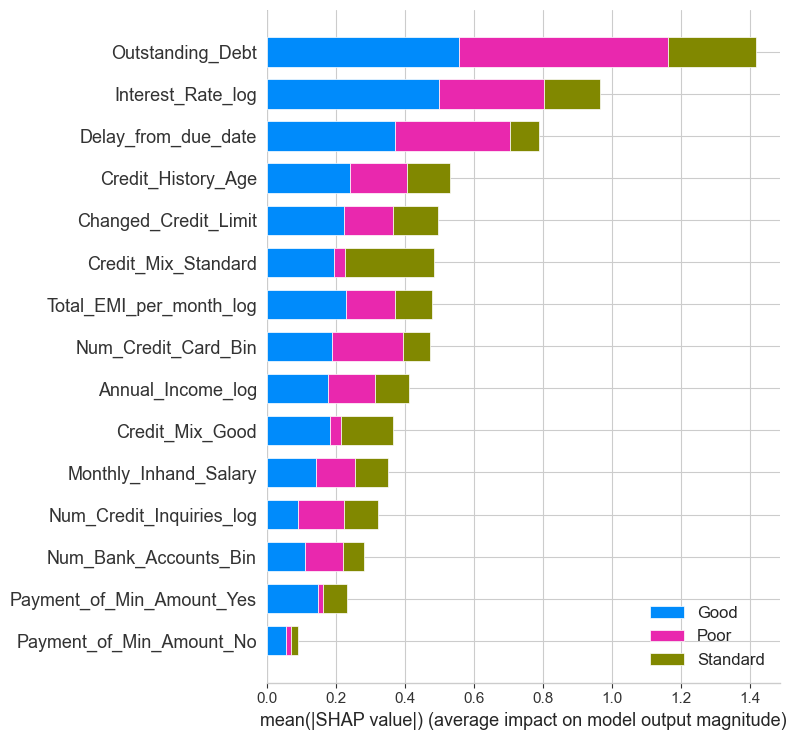

In [123]:
print("="*80)
print("4. SHAP VALUES (Model Explainability)")
print("="*80)

# Initialize explainer
explainer = shap.TreeExplainer(xgb_final)

# Calculate SHAP values (using a sample if dataset is very large)
sample_idx = np.random.choice(X_val_selected.shape[0], min(2000, X_val_selected.shape[0]), replace=False)
X_shap = X_val_selected.iloc[sample_idx]
shap_values = explainer.shap_values(X_shap)

# Plot Summary
plt.figure(figsize=(12, 8))
print("SHAP Summary Plot (Impact on model output):")
shap.summary_plot(shap_values, X_shap, plot_type="bar", class_names=class_names)

5. DATA SATURATION CHECK (Learning Curve)
Calculating performance on different training set sizes...
  Size: 10% (5829 samples) -> Train F1: 0.9123 | Val F1: 0.6962
  Size: 20% (11658 samples) -> Train F1: 0.9186 | Val F1: 0.7182
  Size: 30% (17488 samples) -> Train F1: 0.9148 | Val F1: 0.7341
  Size: 40% (23317 samples) -> Train F1: 0.9110 | Val F1: 0.7500
  Size: 50% (29147 samples) -> Train F1: 0.9105 | Val F1: 0.7573
  Size: 60% (34976 samples) -> Train F1: 0.9082 | Val F1: 0.7670
  Size: 70% (40805 samples) -> Train F1: 0.9054 | Val F1: 0.7754
  Size: 80% (46635 samples) -> Train F1: 0.9031 | Val F1: 0.7789
  Size: 90% (52464 samples) -> Train F1: 0.9019 | Val F1: 0.7869
  Size: 100% (58294 samples) -> Train F1: 0.9001 | Val F1: 0.7925


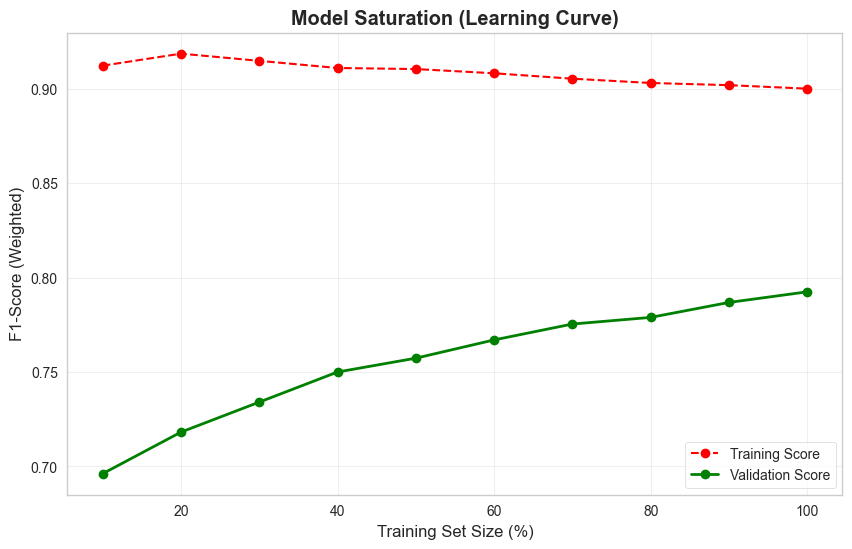

In [124]:
print("="*80)
print("5. DATA SATURATION CHECK (Learning Curve)")
print("="*80)
print("Calculating performance on different training set sizes...")

# Setup sizes (10% to 100%)
train_sizes = np.linspace(0.1, 1.0, 10)
train_f1_scores = []
val_f1_scores = []


for fraction in train_sizes:
    # Determine slice index
    limit = int(len(X_train_selected) * fraction)

    # Slice data
    X_partial = X_train_selected.iloc[:limit]
    y_partial = y_train.iloc[:limit]
    w_partial = sample_weights[:limit]

    # Initialize new instance with best params
    model_temp = xgb.XGBClassifier(**best_xgb_params)

    # Train
    model_temp.fit(X_partial, y_partial, sample_weight=w_partial)

    # Evaluate on Train (Partial)
    train_pred = model_temp.predict(X_partial)
    train_f1 = f1_score(y_partial, train_pred, average='weighted')
    train_f1_scores.append(train_f1)

    # Evaluate on Validation (Full - acts as a constant benchmark)
    val_pred = model_temp.predict(X_val_selected)
    val_f1 = f1_score(y_val, val_pred, average='weighted')
    val_f1_scores.append(val_f1)

    print(f"  Size: {int(fraction*100)}% ({limit} samples) -> Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

# Plotting Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, train_f1_scores, 'o--', color='red', label='Training Score')
plt.plot(train_sizes * 100, val_f1_scores, 'o-', color='green', linewidth=2, label='Validation Score')

plt.title('Model Saturation (Learning Curve)', fontweight='bold')
plt.xlabel('Training Set Size (%)')
plt.ylabel('F1-Score (Weighted)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()